In [15]:

import tensorflow as tf

# %pip install opencv-python
# %pip install mitdeeplearning --quiet
import mitdeeplearning as mdl
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display as ipythondisplay
from scipy.io.wavfile import write
assert len(tf.config.list_physical_devices('GPU')) > 0

AssertionError: 

In [3]:
constant1 = tf.constant("Tennis", tf.string)  # 0d
sports = tf.constant(["Tennis", "Basketball"], tf.string)  # 1d
matrix = tf.constant([[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12]], tf.int32)  # 2d
images = tf.zeros([10, 256, 256, 3], tf.int32)  # 4d

a = tf.constant(15)
b = tf.constant(61)
c = a + b
d = a - b
e = a * b

In [7]:
class DenseLayer(tf.keras.layers.Layer):
    def __init__(self, n_output_nodes):
        super(DenseLayer, self).__init__()
        self.n_output_nodes = n_output_nodes

    def build(self, input_shape):
        d = int(input_shape[-1])
        self.W = self.add_weight("weight", shape=[d, self.n_output_nodes])
        self.b = self.add_weight("bias", shape=[1, self.n_output_nodes])

    def call(self, x):
        z = tf.matmul(x, self.W) + self.b
        y = tf.sigmoid(z)
        return y

tf.keras.utils.set_random_seed(1)
layer = DenseLayer(3)
layer.build((1,2))
x_input = tf.constant([[1,2.]],shape=(1,2))
y=layer.call(x_input)

print(x_input)
print(y)

tf.Tensor([1. 2.], shape=(2,), dtype=float32)
tf.Tensor([[0.27064407 0.18269512 0.50374055]], shape=(1, 3), dtype=float32)


In [9]:
n_output_nodes =3 
model = tf.keras.Sequential()
dense_layer = tf.keras.layers.Dense(n_output_nodes,activation='sigmoid')
model.add(dense_layer)

print(model(x_input))

tf.Tensor([[0.18752207 0.23909676 0.3213029 ]], shape=(1, 3), dtype=float32)


In [ ]:
class IdModel(tf.keras.Model):
    def __init(self,n_output_nodes):
        super(IdModel,self).__init__()
        self.dense_layer = tf.keras.layers.Dense(n_output_nodes,activation='sigmoid')
        
    def call(self,inputs,isidentity=False):
        x=self.dense_layer(inputs)
        if(isidentity):
            return inputs
        else:
            return x

In [ ]:
x = tf.Variable(3.0)
with tf.GradientTape() as tape:
    y = x**2
dy_dx = tape.gradient(y, x)

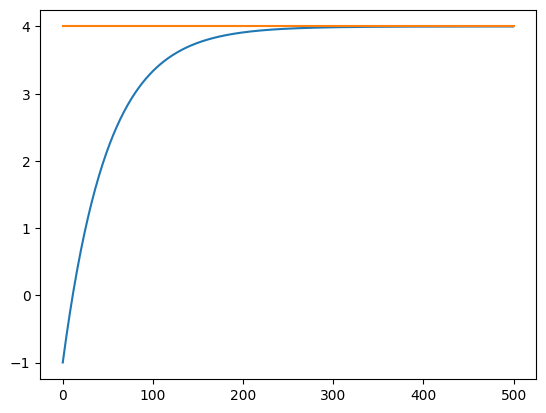

In [10]:
x = tf.Variable([tf.random.normal([1])])
lr = 1e-2 
history = []
x_f = 4 

for i in range(500):
    with tf.GradientTape() as tape:
        loss = (x-x_f) ** 2 
    grad = tape.gradient(loss,x)
    new_x = x- lr * grad 
    x.assign(new_x)
    history.append(x.numpy()[0])

plt.plot(history)
plt.plot([0,500],[x_f,x_f])

In [3]:
songs = mdl.lab1.load_training_data()
example_song = songs[0]

songs_joined = "\n\n".join(songs)
vocab = sorted(set(songs_joined))

char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

def vectorize_string(string):
  return np.array([char2idx[char] for char in string], dtype=int)
vectorized_songs = vectorize_string(songs_joined)

Found 817 songs in text


In [10]:
def get_batch(vectorized_songs, seq_length, batch_size):
  n = vectorized_songs.shape[0] - 1
  idx = np.random.choice(n-seq_length, batch_size)

  input_batch = [vectorized_songs[i : i + seq_length] for i in idx]
  output_batch = [vectorized_songs[i + 1 : i + seq_length + 1] for i in idx]
 
  x_batch = np.reshape(input_batch, [batch_size, seq_length])
  y_batch = np.reshape(output_batch, [batch_size, seq_length])
  return x_batch, y_batch

x_batch, y_batch = get_batch(vectorized_songs, seq_length=5, batch_size=1)

def LSTM(rnn_units):
  return tf.keras.layers.LSTM(
    rnn_units,
    return_sequences=True,
    recurrent_initializer='glorot_uniform',
    recurrent_activation='sigmoid',
    stateful=True,
  )
  
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),
    LSTM(rnn_units),
   tf.keras.layers.Dense(vocab_size)
  ])
  return model

model = build_model(len(vocab), embedding_dim=256, rnn_units=1024, batch_size=32)
model.summary()

x, y = get_batch(vectorized_songs, seq_length=100, batch_size=32)
pred = model(x)

sampled_indices = tf.random.categorical(pred[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()
sampled_indices

def compute_loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss = compute_loss(x, pred) 

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (32, None, 256)           21248     
                                                                 
 lstm_3 (LSTM)               (32, None, 1024)          5246976   
                                                                 
 dense_3 (Dense)             (32, None, 83)            85075     
                                                                 
Total params: 5353299 (20.42 MB)
Trainable params: 5353299 (20.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


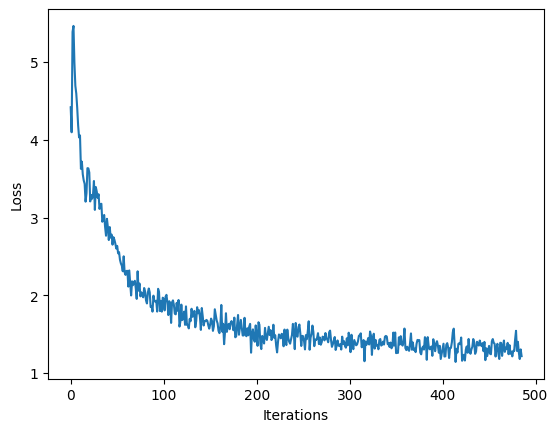

 16%|█▌        | 486/3000 [03:53<20:08,  2.08it/s]


KeyboardInterrupt: 

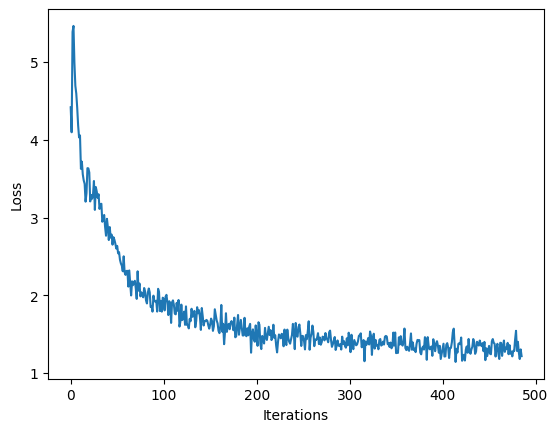

In [11]:
vocab_size = len(vocab)
params = dict(
    num_training_iterations=3000,  # Increase this to train longer
    batch_size=8,  # Experiment between 1 and 64
    seq_length=100,  # Experiment between 50 and 500
    learning_rate=5e-3,  # Experiment between 1e-5 and 1e-1
    embedding_dim=256,
    rnn_units=1024,  # Experiment between 1 and 2048
)
checkpoint_dir = "./training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")


# def create_experiment():
#     if "experiment" in locals():
#         experiment.end()

#     experiment = comet_ml.Experiment(
#         api_key=COMET_API_KEY, project_name="6S191_Lab1_Part2"
#     )

#     for param, value in params.items():
#         experiment.log_parameter(param, value)
#     experiment.flush()

#     return experiment


model = build_model(
    vocab_size, params["embedding_dim"], params["rnn_units"], params["batch_size"]
)
optimizer = tf.keras.optimizers.legacy.Adam(params["learning_rate"])


@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        y_hat = model(x)
        loss = compute_loss(y, y_hat)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss


history = []
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel="Iterations", ylabel="Loss")
# experiment = create_experiment()

if hasattr(tqdm, "_instances"):
    tqdm._instances.clear()
for iter in tqdm(range(params["num_training_iterations"])):
    x_batch, y_batch = get_batch(
        vectorized_songs, params["seq_length"], params["batch_size"]
    )
    loss = train_step(x_batch, y_batch)
    # experiment.log_metric("loss", loss.numpy().mean(), step=iter)
    history.append(loss.numpy().mean())
    plotter.plot(history)
    if iter % 100 == 0:
        model.save_weights(checkpoint_prefix)

model.save_weights(checkpoint_prefix)
# experiment.flush()

In [14]:
model = build_model(vocab_size=vocab_size, embedding_dim=params["embedding_dim"], rnn_units=params["rnn_units"], batch_size=1)
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

def generate_text(model, start_string, generation_length=1000):
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)
  text_generated = []
  model.reset_states()
  tqdm._instances.clear()

  for i in tqdm(range(generation_length)):
      predictions = model(input_eval)
      predictions = tf.squeeze(predictions, 0)
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
      input_eval = tf.expand_dims([predicted_id], 0)
      text_generated.append(idx2char[predicted_id])

  return (start_string + ''.join(text_generated))

generated_text = generate_text(model, start_string="X", generation_length=1000)
print(generated_text)

100%|██████████| 1000/1000 [00:03<00:00, 291.77it/s]

X:1/8886,]2/g/e/|dc Bc|dF FA|BFA DEF|c2B AFD|!
DFA BAG|Bde ecB A2:|!

X:46
T:Barly Donrie
Z: id:dc-jig-2
M:6/8
L:1/8
K:D Major
A|dcBd A2Bd|gfed c2cB|A2G2 d2B2|dfed cAFF|G2DA GEDB|!
F2EF =A,DDF|D2Gc c2cA|dcBc Beef|!
faaf g2ba|bgaf gfef|(3^fge d2ed|c2e^c d2AG|FGFA G2cA|efed efg2|B2G2 E3B|D2E2 D2:|!

X:398
T:Pliphy Jala
Z: id:dc-reel-121
M:C
L:1/8
K:E Dorian
D|Aa bge g2e|dBA ABA|dcd e2d|ecB c2A|G2A B2A GAB|!
B2FG AGFD|GFAD Adff|^cA2 def|!
a2A2 egdB|cBcBA|BcEA ABd:|!
g2ea aaaf|dBGB A2BA|!
a2ef gfed|BcdA ecde|edcA BGGA|B2:|!
B|AAFG BAcA|A2AF E2D2|DFFA Bdef|gbeg f2c2|A2F2 A2cd|^cdef gfed|Ade2 g^fdd f2Bd|edBG FGFE|GFD2 BBdg|fddB AGG2|dgfd cdef|!
BcdB cdef|g2ef dB:|!
A|BGA2 d6 B2g2|f2ag e2:|!
aged Bdd2 d2A2|cde2 edBc|gfg efg|edd edd|c2A D3|ABc d2b agf|ece g2f gfe|f2af defe|fded AE^d|!
dged cBAG|AFDB d2dB|!
DGBc d2:|!
g|f2fd ecec|d2Bd BedB|Acdc ecAF D2FG|d2G2 DDED|ADD^F G2G2|!
f2fg bgfe|dBdB B=cde|DcA GED|DED FAB|cAG E3:|!

X:243
T:Doule
Z: id:dc-reel-270
M:C
L:1/8
K:E Dorian
B|DFDd Bcdc|BFBd e

In [ ]:
### Play back generated songs ###

generated_songs = mdl.lab1.extract_song_snippet(generated_text)

for i, song in enumerate(generated_songs):
  # Synthesize the waveform from a song
  waveform = mdl.lab1.play_song(song)

  # If its a valid song (correct syntax), lets play it!
  if waveform:
    print("Generated song", i)
    ipythondisplay.display(waveform)

    numeric_data = np.frombuffer(waveform.data, dtype=np.int16)
    wav_file_path = f"output_{i}.wav"
    write(wav_file_path, 88200, numeric_data)

    # save your song to the Comet interface -- you can access it there
    # experiment.log_asset(wav_file_path)